# Big Data Management Project 3:
## Analysing Flight Interconnected Data


### Imports & Setup

In [1]:
import pyspark
!pip install delta-spark
from delta import configure_spark_with_delta_pip

!pip install graphframes
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType

# 🔧 Spark Session with GraphFrames
builder = pyspark.sql.SparkSession.builder.appName("FlightGraphAnalysis") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "1") \
    .config("spark.driver.memory", "8g") 


spark = configure_spark_with_delta_pip(
    builder, extra_packages=["graphframes:graphframes:0.8.4-spark3.5-s_2.12"]
).getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", spark._sc.defaultParallelism)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)
spark.conf.set("spark.sql.shuffle.partitions", "50")  # default is 200
spark.conf.set("spark.default.parallelism", "50")
spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoints")


import graphframes as gf 

### Data download/extraction

In [2]:
!pip install gdown
import gdown
import os
import zipfile

zip_filename = "input/2009.csv.zip"
csv_filename = "input/2009.csv"

if os.path.exists(csv_filename):
    print(f"{csv_filename} already exists. Nothing to do.")

elif os.path.exists(zip_filename):
    print(f"{csv_filename} not found, but {zip_filename} exists. Unzipping...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall("input/.")
    print("Unzipping complete.")

else:
    print("File is missing, importing from Google Drive")
    !gdown 1trFtRCe3xPBLr90hIWBF__OqppEnJPR_ -O input/
    print("File downloaded, going to unzip")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall("input/.")
    print("Unzipping complete.")

input/2009.csv already exists. Nothing to do.


### Data selection

##### We loaded the flight dataset and selected only the necessary columns. This helped reduce memory usage and speeds up processing.

In [2]:
df = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2009.csv")
      .select("ORIGIN", "DEST", "FL_DATE", "DISTANCE"))  # selection

df.limit(20).show()

+------+----+----------+--------+
|ORIGIN|DEST|   FL_DATE|DISTANCE|
+------+----+----------+--------+
|   DCA| EWR|2009-01-01|   199.0|
|   EWR| IAD|2009-01-01|   213.0|
|   EWR| DCA|2009-01-01|   199.0|
|   DCA| EWR|2009-01-01|   199.0|
|   IAD| EWR|2009-01-01|   213.0|
|   ATL| EWR|2009-01-01|   745.0|
|   CLE| ATL|2009-01-01|   554.0|
|   DCA| EWR|2009-01-01|   199.0|
|   EWR| DCA|2009-01-01|   199.0|
|   EWR| DCA|2009-01-01|   199.0|
|   DCA| EWR|2009-01-01|   199.0|
|   EWR| DCA|2009-01-01|   199.0|
|   CLE| DCA|2009-01-01|   310.0|
|   DCA| EWR|2009-01-01|   199.0|
|   ORD| EWR|2009-01-01|   719.0|
|   EWR| ORD|2009-01-01|   719.0|
|   ORD| EWR|2009-01-01|   719.0|
|   EWR| ORD|2009-01-01|   719.0|
|   ORD| EWR|2009-01-01|   719.0|
|   EWR| ORD|2009-01-01|   719.0|
+------+----+----------+--------+



### Graph
#### Verticles - airports
#### Edges - flights
##### In this graph each airport is represented as a vertex and each flight as a directed edge. The `airports_df` shows unique airport codes from both origin and destination columns. The `edges_df` contains flight connections with `src` (origin) and `dst` (destination). Using these, we constructed the `flights_graph`.

In [3]:
#remove rows with null values
df_cleaned = df.dropna(subset=["ORIGIN", "DEST"])

#Vertices - airports 
airports_df = df.select(F.col("ORIGIN").alias("id")).union(
    df.select(F.col("DEST").alias("id"))
).distinct()

#Edges - flights
edges_df = df.select(
    F.col("ORIGIN").alias("src"),
    F.col("DEST").alias("dst")
)

#GraphFrame
flights_graph = gf.GraphFrame(airports_df, edges_df)
print("Airports total:", flights_graph.vertices.count())
print("Flights total:", flights_graph.edges.count())

flights_graph.cache()
airports_df.cache()
edges_df.cache()
display(flights_graph)

print("The airports from data: ") 
display(flights_graph.vertices)
print("The flights between airports from data: ")
display(flights_graph.edges)

Airports total: 296
Flights total: 6429338


GraphFrame(v:[id: string], e:[src: string, dst: string])

The airports from data: 


id
CLT
BNA
HNL
TVC
CLL
BGM
LCH
SHV
TEX
PSC


The flights between airports from data: 


src,dst
DCA,EWR
EWR,IAD
EWR,DCA
DCA,EWR
IAD,EWR
ATL,EWR
CLE,ATL
DCA,EWR
EWR,DCA
EWR,DCA


### Query 1

### Custom in-degree, out-degree, degree, triangle count

##### First, we computed the in-degree by counting how many flights arrive at each airport (dst). Then, we calculated the out-degree by counting how many flights depart from each airport (src). Finally, we combined both to compute the total degree for each airport by summing in-degree and out-degree. Missing values were handled using coalesce.

In [5]:
# In-degree
in_degree_df = edges_df.groupBy("dst").count() \
    .withColumnRenamed("dst", "id") \
    .withColumnRenamed("count", "inDegree")

# Out-degree
out_degree_df = edges_df.groupBy("src").count() \
    .withColumnRenamed("src", "id") \
    .withColumnRenamed("count", "outDegree")

# Total degree (merge in & out)
degree_df = in_degree_df.join(out_degree_df, on="id", how="full_outer") \
    .withColumn("inDegree", F.coalesce(F.col("inDegree"), F.lit(0))) \
    .withColumn("outDegree", F.coalesce(F.col("outDegree"), F.lit(0))) \
    .withColumn("totalDegree", F.col("inDegree") + F.col("outDegree"))

display(degree_df)

id,inDegree,outDegree,totalDegree
ABE,4037,4034,8071
ABI,2490,2490,4980
ABQ,35577,35582,71159
ABY,997,995,1992
ACK,343,342,685
ACT,1052,1053,2105
ACV,3364,3370,6734
ACY,522,522,1044
ADK,103,103,206
ADQ,631,631,1262


##### Calculating the number of unique triangles in the graph by joining edges to form two-step paths (A → B → C) and then checking if a closing edge (C → A) exists. To avoid duplicate counting, we sorted and filtered nodes (A < B < C). The result of Q2 - total triangles in the graph is 16015

In [6]:
from pyspark.sql import functions as F

edges_filtered = edges_df.select(
    F.least("src", "dst").alias("src"),
    F.greatest("src", "dst").alias("dst")
).distinct().cache()

# two-edge paths
paths_two = edges_filtered.alias("e1").join(
    edges_filtered.alias("e2"),
    F.col("e1.dst") == F.col("e2.src")
).select(
    F.col("e1.src").alias("A"),
    F.col("e1.dst").alias("B"),
    F.col("e2.dst").alias("C")
).filter("A < B AND B < C")

# checking if (a,c) exists
triangles = paths_two.join(
    edges_filtered.alias("e3"),
    (F.col("e3.src") == F.col("A")) & (F.col("e3.dst") == F.col("C"))
).select("A", "B", "C").distinct()

# count per airport
triangle_airports = triangles.select("A").union(
    triangles.select("B")
).union(
    triangles.select("C")
)

# count how many times each airport appears in triangles
triangle_counts = triangle_airports.groupBy("A").count() \
    .withColumnRenamed("A", "airport") \
    .withColumnRenamed("count", "triangle_count") \
    .orderBy(F.desc("triangle_count"))

display(triangle_counts)

airport,triangle_count
ATL,1761
ORD,1678
DFW,1503
DTW,1479
DEN,1438
MSP,1396
IAH,1338
CVG,1261
LAS,1231
PHX,1191


In [7]:
# validation
triangle_check = flights_graph.triangleCount()

# Show top 10 airports with highest triangle counts
triangle_check.select("id", "count") \
    .withColumnRenamed("id", "airport") \
    .withColumnRenamed("count", "triangle_count") \
    .orderBy(F.desc("triangle_count")) \
    .show(10, truncate=False)

+-------+--------------+
|airport|triangle_count|
+-------+--------------+
|ATL    |1761          |
|ORD    |1678          |
|DFW    |1503          |
|DTW    |1479          |
|DEN    |1438          |
|MSP    |1396          |
|IAH    |1338          |
|CVG    |1261          |
|LAS    |1231          |
|PHX    |1191          |
+-------+--------------+
only showing top 10 rows



### Plot for triangle count

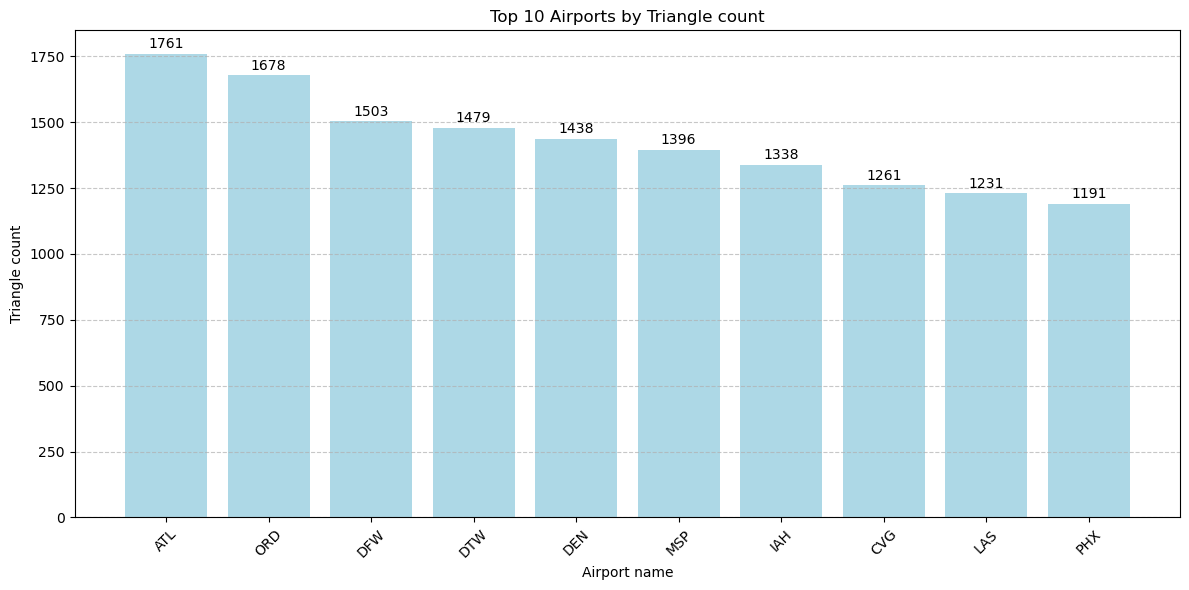

In [8]:
import matplotlib.pyplot as plt
triangle_counts_top10 = triangle_counts.limit(10).toPandas()

plt.figure(figsize=(12, 6))
bars = plt.bar(triangle_counts_top10["airport"], triangle_counts_top10["triangle_count"], color='lightblue')
plt.title("Top 10 Airports by Triangle count")
plt.xlabel("Airport name")
plt.ylabel("Triangle count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Query  2

In [9]:
# Count total triangles
triangle_count = triangles.count()
print(f"Total triangles in the graph: {triangle_count}")

# Display some triangles
triangles.show(5, truncate=False)

Total triangles in the graph: 16015
+---+---+---+
|A  |B  |C  |
+---+---+---+
|CLE|LGA|PBI|
|CLE|LGA|MSN|
|CLE|LGA|MDW|
|CLE|LGA|ORD|
|CLE|LGA|RDU|
+---+---+---+
only showing top 5 rows



In [10]:
### validation ###
triangle_check_df = flights_graph.triangleCount()

from pyspark.sql.functions import sum as Fsum
total_triangles_gf = triangle_check_df.agg(Fsum("count") / 3).first()[0]
print(f"Total triangles: {int(total_triangles_gf)}")

Total triangles: 16015


### Query 3
#### Centrality Measure (custom) – Degree Centrality 
##### Degree Centrality Normalization:  We normalized the totalDegree by dividing it by the total number of airports in the data. Here we can see that the resulting values can be compared proportionally across the entire graph. This can help to understand how much each airport influences the flight network.

In [11]:
degree_centrality = degree_df.withColumn("degreeCentrality", F.col("totalDegree") / airports_df.count())
display(degree_centrality.orderBy("degreeCentrality", ascending=False))

id,inDegree,outDegree,totalDegree,degreeCentrality
ATL,417457,417449,834906,2820.6283783783783
ORD,313769,313848,627617,2120.3277027027025
DFW,264398,264396,528794,1786.4662162162163
DEN,235700,235675,471375,1592.4831081081081
LAX,192916,192879,385795,1303.3614864864865
PHX,183491,183502,366993,1239.8412162162163
IAH,182088,182097,364185,1230.3547297297298
LAS,153984,153993,307977,1040.462837837838
DTW,152075,152081,304156,1027.554054054054
SFO,136532,136488,273020,922.3648648648649


In [12]:
# validation
graphframe_degrees = flights_graph.degrees
total_airports = airports_df.count()
graphframe_degrees = graphframe_degrees.withColumn(
    "degreeCentrality", F.col("degree") / total_airports
)
graphframe_degrees.orderBy(F.desc("degreeCentrality")).show(10, truncate=False)

+---+------+------------------+
|id |degree|degreeCentrality  |
+---+------+------------------+
|ATL|834906|2820.6283783783783|
|ORD|627617|2120.3277027027025|
|DFW|528794|1786.4662162162163|
|DEN|471375|1592.4831081081081|
|LAX|385795|1303.3614864864865|
|PHX|366993|1239.8412162162163|
|IAH|364185|1230.3547297297298|
|LAS|307977|1040.462837837838 |
|DTW|304156|1027.554054054054 |
|SFO|273020|922.3648648648649 |
+---+------+------------------+
only showing top 10 rows



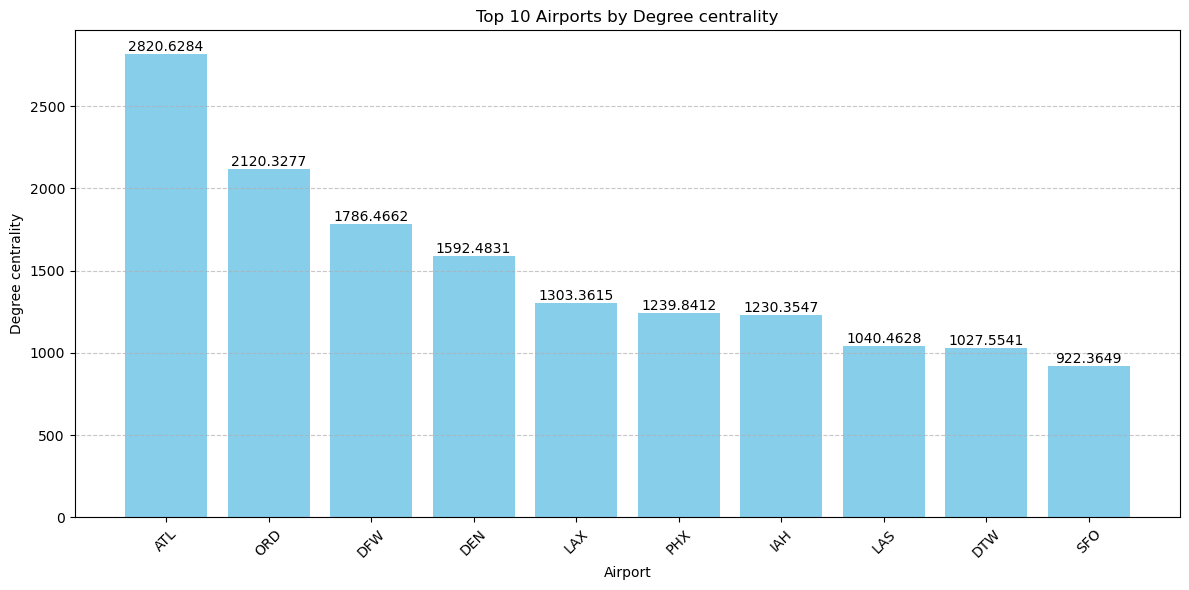

In [13]:
top10_degree = degree_centrality.orderBy("degreeCentrality", ascending=False).limit(10).toPandas()

plt.figure(figsize=(12, 6))
bars = plt.bar(top10_degree["id"], top10_degree["degreeCentrality"], color='skyblue')
plt.title("Top 10 Airports by Degree centrality")
plt.xlabel("Airport")
plt.ylabel("Degree centrality")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f"{yval:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Query 4

In [14]:
from pyspark.sql import functions as F
from pyspark.sql.functions import lit

# Damping factor
d = 0.85
N = flights_graph.vertices.count()

# Initial rank = 1.0 per node
ranks = flights_graph.vertices.withColumn("rank", lit(1.0))

# Out-degree per node
out_deg = flights_graph.edges.groupBy("src").count().withColumnRenamed("count", "out_deg")

for i in range(10):
    # Join edges with ranks and out-degrees
    contribs = flights_graph.edges.join(ranks, flights_graph.edges.src == ranks.id, "left") \
        .join(out_deg, flights_graph.edges.src == out_deg.src, "left") \
        .select(
            flights_graph.edges.dst.alias("id"),
            (ranks["rank"] / out_deg["out_deg"]).alias("contrib")
        )

    # Sum contributions for each destination node
    contribs_sum = contribs.groupBy("id").agg(F.sum("contrib").alias("total_contrib"))

    # Calculate lost rank from dangling nodes (those with no out_deg)
    dangling = ranks.join(out_deg, ranks.id == out_deg.src, "left_anti") \
        .agg(F.sum("rank").alias("dangling_rank")) \
        .collect()[0]["dangling_rank"] or 0.0

    # Redistribute dangling rank evenly
    dangling_contrib = dangling / N

    # New rank with teleportation and dangling compensation
    ranks = contribs_sum.withColumn(
        "rank", (1 - d) / N + d * (F.col("total_contrib") + dangling_contrib)
    ).select("id", "rank")

# (Optional) Scale like GraphFrames (multiply by N)
#ranks = ranks.withColumn("rank", F.col("rank") * N)

In [15]:
#total_rank = ranks.agg(F.sum("rank")).collect()[0][0]
#ranks = ranks.withColumn("rank", F.col("rank") / total_rank * N)
ranks.orderBy("rank", ascending=False).show(20, truncate=False)

+---+------------------+
|id |rank              |
+---+------------------+
|ATL|3.7746932311897385|
|ORD|2.850520736190481 |
|DFW|2.4056640181384736|
|DEN|2.163725650494938 |
|LAX|1.778803317075194 |
|PHX|1.6883137905071532|
|IAH|1.6533685515850127|
|LAS|1.4148972198032859|
|DTW|1.3801447747730897|
|SFO|1.262865778039641 |
|SLC|1.2240942931960062|
|MSP|1.1011494882352182|
|MCO|1.095789144824452 |
|JFK|1.0868795515170306|
|EWR|1.076759725872456 |
|CLT|1.0558085232802255|
|BOS|1.0017639456686338|
|SEA|0.9878947083935656|
|BWI|0.9131998814888409|
|LGA|0.9079504697804851|
+---+------------------+
only showing top 20 rows



In [16]:
g_pagerank = flights_graph.pageRank(resetProbability=0.15, maxIter=10)

print("Top 10 most important airports")
result = g_pagerank.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False)
display(result)

Top 10 most important airports


id,pagerank
ATL,18.905010413236518
ORD,12.927110422702082
DFW,11.735613068886845
DEN,9.998483451764816
LAX,7.726101869874797
IAH,7.159305038124472
PHX,7.065371562598674
SLC,7.038754134167305
DTW,7.01996853674844
SFO,5.904248175402539


In [8]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, sum as Fsum, coalesce

# Number of nodes (vertices)
N = flights_graph.vertices.count()

# Damping factor and number of iterations
damping = 0.85
iterations = 10

# Initialize ranks with 1 / N for each vertex
ranks = flights_graph.vertices.withColumn("PageRank", lit(1.0 / N))

# Compute out-degree for each source node
out_degree_df = edges_df.groupBy("src").count().withColumnRenamed("count", "outDegree")

# Run PageRank for a set number of iterations
for i in range(iterations):
    contribs = edges_df \
        .join(ranks, edges_df.src == ranks.id, "left") \
        .join(out_degree_df, "src") \
        .withColumn("contrib", col("PageRank") / col("outDegree")) \
        .groupBy("dst") \
        .agg(Fsum("contrib").alias("contrib"))

    # Update ranks using the contributions from the previous step
    ranks = ranks.join(contribs, ranks.id == contribs.dst, how="left_outer") \
        .select(ranks.id, ((1 - damping) / N + damping * coalesce(col("contrib"), lit(0.0))).alias("PageRank"))

# Show the top 10 ranks
ranks.orderBy("PageRank", ascending=False).show(10, truncate=False)

+---+--------------------+
|id |PageRank            |
+---+--------------------+
|ATL|0.03829482725760366 |
|DFW|0.030362162638916196|
|ORD|0.02814470298652412 |
|DTW|0.026089008410129615|
|MSP|0.02565197884466995 |
|DEN|0.02373745663718426 |
|SLC|0.022853022910430842|
|IAH|0.019129464884312435|
|LAX|0.01713158721564218 |
|CVG|0.016408078973259174|
+---+--------------------+
only showing top 10 rows



In [6]:
from pyspark.sql.functions import col, lit, sum as Fsum, coalesce

N = airports_df.count()
damping = 0.85
iterations = 10

ranks = airports_df.withColumn("PageRank", lit(1.0 / N))

out_degree_df = edges_df.groupBy("src").count().withColumnRenamed("count", "outDegree")

for i in range(iterations):
    contribs = edges_df \
        .join(ranks, edges_df.src == ranks.id, "left") \
        .join(out_degree_df, "src") \
        .withColumn("contrib", col("PageRank") / col("outDegree")) \
        .groupBy("dst") \
        .agg(Fsum("contrib").alias("contrib"))

    ranks = airports_df.join(contribs, airports_df.id == contribs.dst, how="left_outer") \
        .select("id", ((1 - damping) / N + damping * coalesce(col("contrib"), lit(0.0))).alias("PageRank"))

ranks.orderBy("PageRank", ascending=False).show(10, truncate=False)

+---+--------------------+
|id |PageRank            |
+---+--------------------+
|ATL|0.03829482725760366 |
|DFW|0.030362162638916196|
|ORD|0.02814470298652412 |
|DTW|0.026089008410129615|
|MSP|0.02565197884466995 |
|DEN|0.02373745663718426 |
|SLC|0.022853022910430842|
|IAH|0.019129464884312435|
|LAX|0.01713158721564218 |
|CVG|0.016408078973259174|
+---+--------------------+
only showing top 10 rows



In [7]:
##validation 
#smaller graph, due to memory and performance issues
#edges_sample = edges_df.sample(False, 0.001, seed=123)
airports_sample = edges_df.select("src").union(edges_df.select("dst")).distinct().withColumnRenamed("src", "id")
small_graph = gf.GraphFrame(airports_sample, edges_df)

pagerank_check = small_graph.pageRank(resetProbability=0.15, maxIter=10)
total_rank = pagerank_check.vertices.agg(F.sum("pagerank").alias("total")).collect()[0]["total"]
normalized_pagerank = pagerank_check.vertices \
    .withColumn("PageRank_norm", F.col("pagerank") / F.lit(total_rank)) \
    .select("id", "PageRank_norm")

normalized_pagerank.orderBy("PageRank_norm", ascending=False).show(10, truncate=False)



+---+--------------------+
|id |PageRank_norm       |
+---+--------------------+
|ATL|0.038294827257603734|
|DFW|0.03036216263891622 |
|ORD|0.028144702986524158|
|DTW|0.02608900841012964 |
|MSP|0.02565197884466997 |
|DEN|0.023737456637184275|
|SLC|0.022853022910430853|
|IAH|0.019129464884312452|
|LAX|0.0171315872156422  |
|CVG|0.016408078973259188|
+---+--------------------+
only showing top 10 rows



### Query 5

In [4]:
from pyspark.sql.functions import col

# Clean the dataset and prepare the edges
df_cleaned = df.dropna(subset=["ORIGIN", "DEST"])

# Create initial edges
edges_df = df_cleaned.select(
    col("ORIGIN").alias("src"),
    col("DEST").alias("dst")
).distinct()

# Create reversed edges for undirected graph (bidirectional)
edges_reversed = edges_df.select(col("dst").alias("src"), col("src").alias("dst"))
undirected_edges = edges_df.union(edges_reversed).distinct()

# Start with one airport (e.g., ATL)
starting_airport = "ATL"
current_frontier = spark.createDataFrame([(starting_airport,)], ["id"])
visited = current_frontier

# Iteratively expand the frontier
# We use a loop to propagate until all connected nodes are visited
while True:
    # Get new neighbors by joining with the edges
    neighbors = current_frontier.join(undirected_edges, current_frontier.id == undirected_edges.src) \
                                 .select(undirected_edges.dst.alias("id")).distinct()
    
    # Exclude already visited nodes
    new_nodes = neighbors.join(visited, on="id", how="left_anti").distinct()
    
    # If no new nodes were found, we've processed all connected components
    if new_nodes.count() == 0:
        break
    
    # Update the frontier and visited
    visited = visited.union(new_nodes).distinct()
    current_frontier = new_nodes

# Final result: all airports in the largest connected component
visited_airports = visited
print("Number of airports in largest connected component (manual BFS):", visited_airports.count())
visited_airports.show(10, truncate=False)  # Show the first 10 airports, adjust as needed

Number of airports in largest connected component (manual BFS): 296
+---+
|id |
+---+
|ATL|
|CLT|
|BNA|
|HNL|
|SHV|
|CVG|
|VPS|
|SJC|
|MSY|
|TLH|
+---+
only showing top 10 rows



In [5]:
# Create the GraphFrame
from graphframes import GraphFrame
airports_df = df_cleaned.select(col("ORIGIN").alias("id")).union(
    df_cleaned.select(col("DEST").alias("id"))
).distinct()

# Create the edges (flights)
edges_df = df_cleaned.select(
    col("ORIGIN").alias("src"),
    col("DEST").alias("dst")
).distinct()

# Initialize the GraphFrame
flights_graph = GraphFrame(airports_df, edges_df)

# Run the connected components algorithm
components_df = flights_graph.connectedComponents()

# Group by component ID and count the number of airports in each component
component_sizes_df = components_df.groupBy("component").count()

# Find the largest component
largest_component_row = component_sizes_df.orderBy(col("count").desc()).first()

# Show the largest component and its size
print(f"Largest component ID: {largest_component_row['component']}")
print(f"Number of airports in the largest component: {largest_component_row['count']}")

# Optionally, show the airports in the largest component
largest_component_airports = components_df.filter(components_df.component == largest_component_row['component'])
largest_component_airports.show(truncate=False)

Largest component ID: 0
Number of airports in the largest component: 296
+---+---------+
|id |component|
+---+---------+
|CLT|0        |
|BNA|0        |
|HNL|0        |
|TVC|0        |
|CLL|0        |
|BGM|0        |
|LCH|0        |
|SHV|0        |
|TEX|0        |
|PSC|0        |
|ERI|0        |
|PSE|0        |
|CVG|0        |
|VPS|0        |
|MSY|0        |
|SJC|0        |
|CIC|0        |
|TOL|0        |
|BUF|0        |
|LGA|0        |
+---+---------+
only showing top 20 rows

